In [1]:
import sys 

import matplotlib.pyplot as plt
import numpy as np
import snntorch
import torch
import snntorch.functional as SF
from matplotlib.pyplot import cm
from snntorch import surrogate

sys.path.append('../')
from src import data
from src import plot_params
from src import temporal_correlation as corr
from src.spiking_neural_network import Snn

In [5]:
database = 'mnist'
batch_size = 128
train_set, test_set, train_loader, test_loader, device = data.set_loader_device(database, batch_size)

dataset_name = 'test_set'
imgs_labels = torch.load(
    f'../data/imgs_labels/{database}_{dataset_name}_imgs_labels.pth'
)

In [19]:
size_layer = 300
num_units_layers = [784, size_layer, size_layer, 10]
spk_neuron = snntorch.Leaky(
    beta=0.5,
    threshold=1,
    reset_mechanism='subtract',
    spike_grad=surrogate.fast_sigmoid(slope=25)
)

model = Snn(spk_neuron, num_units_layers).to(device=device)
loss = SF.ce_count_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [20]:
def train(
        model,
        loss,
        optimizer,
        train_loader,
        batch_size: int,
        device: str,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    training_time = 25

    train_loss = np.zeros(training_time)
    train_acc = np.zeros(training_time)

    for batch_idx, (train_inputs, train_labels) in enumerate(train_loader):
        train_inputs = train_inputs.to(device)
        train_labels = train_labels.to(device)

        layers = model.forward(train_inputs.view(batch_size, -1))

        train_outputs = layers[-1][0]
        train_loss_batch = loss(train_outputs, train_labels)

        optimizer.zero_grad()
        train_loss_batch.backward()
        optimizer.step()

        train_loss[batch_idx] = train_loss_batch.item()
        train_acc[batch_idx] = SF.accuracy_rate(train_outputs, train_labels)
        if batch_idx == training_time -1:
            break

        print("Training Time:", batch_idx)

    return train_loss, train_acc

In [21]:
train_loss, train_acc = train(model, loss, optimizer, train_loader, batch_size, device)

Training Time: 0
Training Time: 1
Training Time: 2
Training Time: 3
Training Time: 4
Training Time: 5
Training Time: 6
Training Time: 7
Training Time: 8
Training Time: 9
Training Time: 10
Training Time: 11
Training Time: 12
Training Time: 13
Training Time: 14
Training Time: 15
Training Time: 16
Training Time: 17
Training Time: 18
Training Time: 19
Training Time: 20
Training Time: 21
Training Time: 22
Training Time: 23


In [22]:
frames = [imgs_labels[str(j)][i] for j in [0,1,6,7] for i in range(500)]
num_frames = len(frames)

In [23]:
checkpoint = {'model_state_dict': model.state_dict()}
layers = model.movie(checkpoint, frames, device)

# Data collection for each layer.
# Number of variables: rho, mem, cur.
num_variable = 3
layer_1 = np.zeros((num_frames, num_variable, model.num_units_layers[1]))
layer_2 = np.zeros((num_frames, num_variable, model.num_units_layers[2]))
layer_3 = np.zeros((num_frames, num_variable, model.num_units_layers[3]))

for t in range(num_frames):
    layer_1[t,:] = layers[t][0][:]
    layer_2[t,:] = layers[t][1][:]
    layer_3[t,:] = layers[t][2][:]

spk_1 = layer_1[:,0,:]
spk_2 = layer_2[:,0,:]
spk_3 = layer_3[:,0,:]
spk = np.stack((spk_1, spk_2))

layer_1_density = np.mean(layer_1, axis=2)
layer_2_density = np.mean(layer_2, axis=2)
layer_3_density = np.mean(layer_3, axis=2)

rho = np.stack(
    (layer_1_density[:,0], layer_2_density[:,0], layer_3_density[:,0]))
mem = np.stack(
    (layer_1_density[:,1], layer_2_density[:,1], layer_3_density[:,1]))

In [24]:
lag_max = 75
delta_t = 150
xi_rho_2 = corr.correlation_time(rho[1], rho[1], lag_max, delta_t)
xi_spk_2 = corr.correlation_time(spk[1], spk[1], lag_max, delta_t)
xi_u_2 = corr.correlation_time(mem[1], mem[1], lag_max, delta_t)

In [25]:
time = np.arange(num_frames)
colors = ['#1b9e77','#d95f02','#7570b3','#e6ab02']
colors_xi = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33']

color_grey = cm.grey(np.linspace(0, 1, 10))
colors_xi = color_grey

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/gt/jt78k22s5wn85dcvp1ghmy2r0000gn/T/ipykernel_6740/2680045328.py:122: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig('../plots/slow_transition_training.png', dpi=300)
/Users/jhdesantana/.virtualenvs/master/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/Users/jhdesantana/.virtualenvs/master/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


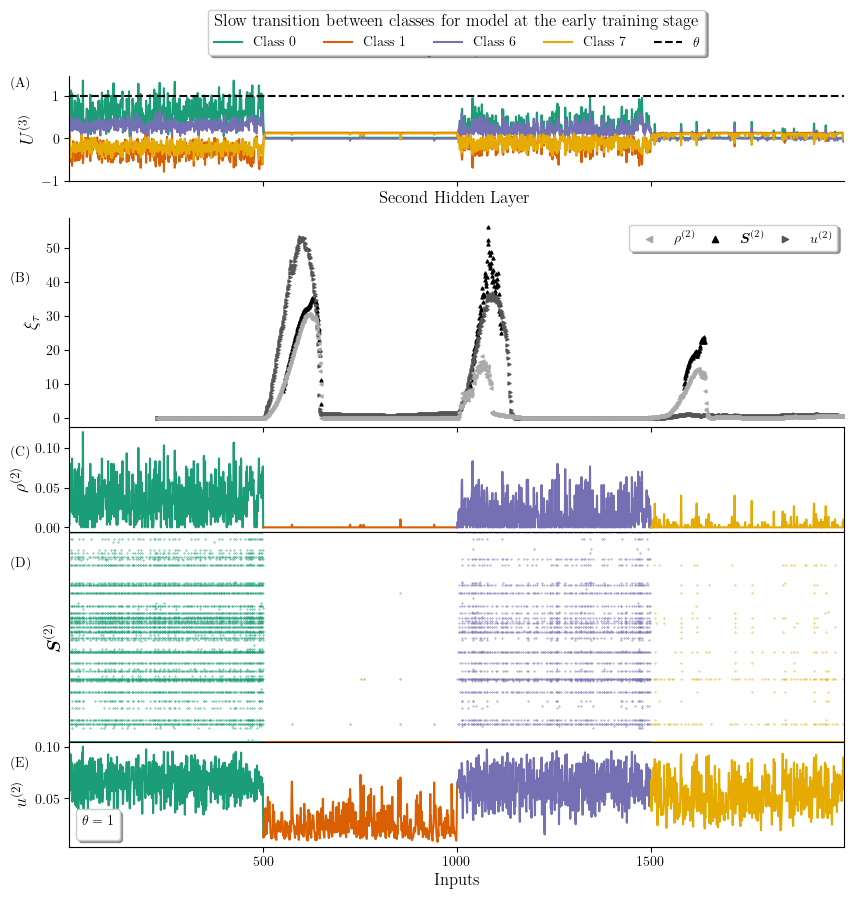

In [30]:
fig = plt.figure(figsize=(10, 16))
grid = plt.GridSpec(
    9, 1,
    # width_ratios=[4, 1],
    height_ratios=[1, 0.35, 2, 1, 2, 1, 1.4, 2, 1],
    hspace=0.0,
    #wspace=0.0)
)
#U_{7}^{(3)
ax_0 = fig.add_subplot(grid[0])

plot1 = ax_0.plot(layer_3[:,1,0], label= r'Class 0', color=colors[0])
plot2 = ax_0.plot(layer_3[:,1,1], label= r'Class 1', color=colors[1])
plot3 = ax_0.plot(layer_3[:,1,6], label= r'Class 6', color=colors[2])
plot4 = ax_0.plot(layer_3[:,1,7], label= r'Class 7', color=colors[3])
plot5 = ax_0.axhline(y=1, color='k', linestyle='--', label=r'$\theta$')

ax_0.spines[['right', 'top']].set_visible(False)
ax_0.margins(x=0)
#ax_0.set_xticks([])
ax_0.set_xticklabels([])
ax_0.set_yticks([-1, 0, 1])
ax_0.set_ylabel(r'$U^{(3)}$', fontsize=13)

ax_0.text(-150, 1.2, '(A)' )
leg_0 = ax_0.legend(loc='upper center', bbox_to_anchor=(0.5, 1.7), ncol=5)
leg_0.set_title('Slow transition between classes for model at the early training stage', prop={'size':12})
ax_0.set_xticks([500, 1000, 1500])
ax_0.text(850, 2, 'Output Layer', fontsize=12)
###############################################################################
ax_space = fig.add_subplot(grid[1])
ax_space.text(0.4, 0.38, 'Second Hidden Layer', fontsize=12)
ax_space.axis('off')


###############################################################################
ax_2 = fig.add_subplot(grid[3])

ax_2.plot(time[:501], rho[1, :501], color=colors[0])
ax_2.plot(time[500:1001],rho[1, 500:1001], color=colors[1])
ax_2.plot(time[1000:1501],rho[1, 1000:1501], color=colors[2])
ax_2.plot(time[1500:],rho[1, 1500:], color=colors[3])

ax_2.spines[['top']].set_visible(False)
ax_2.margins(x=0)
ax_2.set_xticks([])
ax_2.set_xticklabels([])
ax_2.set_ylabel(r'$\rho^{(2)}$', fontsize=13)
ax_2.text(-150, 0.09, '(C)' )

##############################################################################
ax_1 = fig.add_subplot(grid[2])

x_shift = np.arange(0+lag_max+delta_t, num_frames)
    
ax_1.scatter(x_shift, xi_rho_2, label=r'$\rho^{(2)}$', s=4.5, marker='<', color=colors_xi[6],zorder=3)
ax_1.scatter(x_shift, xi_spk_2, label=r'$\boldsymbol{{S}}^{(2)}$', s=4.5, marker='^', color=colors_xi[0])
ax_1.scatter(x_shift, xi_u_2, label=r'$u^{(2)}$', s=4.5, marker='>',color=colors_xi[3], zorder=2)

ax_1.scatter(np.arange(0, num_frames),np.zeros(num_frames), color=colors_xi[9])

ax_1.spines[['right', 'top']].set_visible(False)
ax_1.margins(x=0)

ax_1.set_xticklabels([])
ax_1.set_ylabel(r'$\xi_\tau$', fontsize=13)
ax_1.set_xticks([500, 1000, 1500])
# ax_1.set_yticks([30, 90])

# ax_1.tick_params(axis="y",direction="in", pad=-15)
# ax_1.text(90, 90, r'$\xi_\tau$', rotation=90, fontsize=14)
# ax_1.set_xlabel('Inputs', loc='right', labelpad=0.1)
lgnd = ax_1.legend(loc='upper right', ncol=3, columnspacing=0.45)
# ax_1.text(1750, 90, '(H)')

lgnd.legend_handles[0]._sizes = [20]
lgnd.legend_handles[1]._sizes = [20]
lgnd.legend_handles[2]._sizes = [20]
#lgnd.legendHandles[2]._legmarker.set_markersize(6)

ax_1.text(-150, 40, '(B)' )

###############################################################################
ax_3 = fig.add_subplot(grid[4])
#ax_3.text(-200, 200, '(C)' )
#n_neurons = spk_2.shape[1]
n_neurons = 300
for i in range(n_neurons):
    y = (n_neurons - i)
    ax_3.scatter(time[:500], y*spk_2[:500,i], s = 0.1, color=colors[0])
    ax_3.scatter(time[500:1000], y*spk_2[500:1000,i], s = 0.1, color=colors[1])
    ax_3.scatter(time[1000:1500], y*spk_2[1000:1500,i], s = 0.1, color=colors[2])
    ax_3.scatter(time[1500:], y*spk_2[1500:,i], s = 0.1, color=colors[3])
    ax_3.margins(x=0)

ax_3.set_yticklabels([])
ax_3.set_ylim([0.1, n_neurons])


ax_3.set_xticklabels([])
ax_3.set_yticks([])
ax_3.set_ylabel(r'$\boldsymbol{S}^{(2)}$', fontsize=13)
ax_3.text(-150, 250, '(D)' )
###############################################################################

ax_4 = fig.add_subplot(grid[5])
#ax_4.text(-200, 0.075, '(D)' )
ax_4.plot(time[:501], mem[1, :501], color=colors[0])
ax_4.plot(time[500:1001], mem[1, 500:1001], color=colors[1])
ax_4.plot(time[1000:1501], mem[1, 1000:1501], color=colors[2])
ax_4.plot(time[1500:], mem[1, 1500:], color=colors[3])

ax_4.margins(x=0)
#ax_4.spines[['right']].set_visible(False)
ax_4.set_xlabel('Inputs', fontsize=12)
ax_4.set_ylabel('$u^{(2)}$', fontsize=13)
#ax_4.set_xticklabels([])
ax_4.set_xticks([500, 1000, 1500])
ax_4.legend(title=r'$\theta = 1$')

ax_4.text(-150, 0.08, '(E)' )
fig.savefig('../plots/slow_transition_training.png', dpi=300)
